In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

RAW_DATA_DIR = '../data/raw/'
CLEAN_DATA_DIR = '../data/clean/'

# Import and process data


### Demographics

In [2]:
demographics_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_Demographics_20170116.csv', 
                               index_col=0, parse_dates=['DOB'], infer_datetime_format=True)
demographics_raw.head()

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEX,RACE,ETHNICITY,DOB,DOD,ZIP_CODE
MRN,,,,,,
28997286,2,7,UN,1958-01-09,NaN,422100000
22710289,2,2,NH,1969-09-11,NaN,370640000
15333065,1,1,NH,1996-12-28,NaN,372060000
11732831,1,2,NH,1991-01-31,NaN,370400000
26724542,2,1,NH,1958-08-19,NaN,421340000


In [3]:
demographics_raw.shape

(529428, 6)

Recode categorical variables to something useful

In [4]:
demographics_raw['male'] = (demographics_raw.SEX==1).astype(int)

In [5]:
demographics_raw['race'] = demographics_raw.RACE.replace(dict(zip(range(1, 8), ['white', 'black', 'native', 'asian', 
                                                     'hispanic', 'other', 'unknown'])))

In [6]:
demographics_raw.race.value_counts()


white       419554
black        52455
unknown      32724
hispanic     13540
asian         9708
other          729
native         718
Name: race, dtype: int64

In [7]:
demographics_raw.ETHNICITY.value_counts()


NH    450556
UN     65332
HL     13540
Name: ETHNICITY, dtype: int64

In [8]:
demographics_raw['hispanic'] = (demographics_raw.ETHNICITY=='HL')
demographics_raw.loc[demographics_raw.ETHNICITY=='UN', 'hispanic'] = np.nan

There are no non-null death dates.

In [9]:
demographics_raw.isnull().mean()


SEX          0.000000
RACE         0.000000
ETHNICITY    0.000000
DOB          0.000000
DOD          1.000000
ZIP_CODE     0.001067
male         0.000000
race         0.000000
hispanic     0.123401
dtype: float64

Drop date of death and ethnicity

In [10]:
demographics = demographics_raw.drop(['DOD', 'ETHNICITY'], axis=1)

In [11]:
demographics.shape

(529428, 7)

### Patient flags

In [12]:
flags = pd.read_csv(RAW_DATA_DIR + '400k_flag_v2.csv', index_col=0)
flags.head()

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,htn_flag,chf_flag,esrd_flag,copd_flag,dprn_flag,hlpd_flag,malig_flag,smoke_flag,ckd_flag,cad_flag,lbp_flag,thyroid_flag,osa_flag,asthma_flag,t1dm_flag,bariatric_surgery_cpt_flag,amputation_cpt_flag
patient_id,,,,,,,,,,,,,,,,,
10000073,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000420,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000933,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10001162,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
flagged_demographics = demographics.join(flags)
flagged_demographics.shape

(529428, 24)

### Weight data

In [14]:
weight_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_weight_20170213.csv', 
                         parse_dates=[1], infer_datetime_format=True)
weight_raw.head()

,MRN,WEIGHT_DATE,WEIGHT,PREGNANCY_INDICATOR
0,7695679,2006-01-27,62.60,1
1,7695679,2006-02-08,62.60,1
2,7695679,2006-02-08,62.60,1
3,7695679,2006-03-08,63.96,1
4,7695679,2006-10-02,65.77,1


In [15]:
weight_raw.shape

(8030810, 4)

Add age to each measurement

In [16]:
weight_age = weight_raw.merge(demographics[['DOB']], left_on='MRN', right_index=True)
weight_age['AGE'] = (weight_age.WEIGHT_DATE - weight_age.DOB).astype('<m8[Y]')

In [17]:
weight_age.head()

,MRN,WEIGHT_DATE,WEIGHT,PREGNANCY_INDICATOR,DOB,AGE
0,7695679,2006-01-27,62.60,1,1980-03-22,25.0
1,7695679,2006-02-08,62.60,1,1980-03-22,25.0
2,7695679,2006-02-08,62.60,1,1980-03-22,25.0
3,7695679,2006-03-08,63.96,1,1980-03-22,25.0
4,7695679,2006-10-02,65.77,1,1980-03-22,26.0


In [18]:
weight_age.AGE.min()

17.0

Index values for individuals with a minimum number of measurements

In [19]:
weight_counts = weight_raw.groupby('MRN')['WEIGHT_DATE'].count()

In [20]:
MIN_MEASUREMENTS = 200
many_weights = weight_counts[weight_counts>MIN_MEASUREMENTS].index.values

In [21]:
filtered_weights = (weight_raw[weight_raw.MRN.isin(many_weights) & (weight_raw.PREGNANCY_INDICATOR==0)]
                        .drop('PREGNANCY_INDICATOR', axis=1))
grouped_weights = filtered_weights.groupby('MRN')

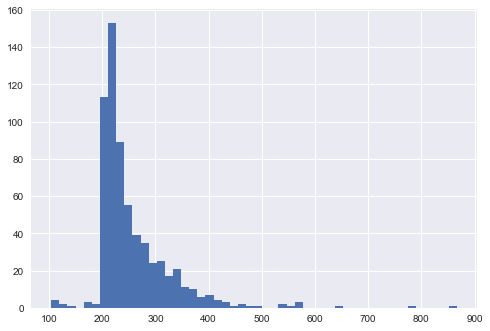

In [22]:
fig, ax = plt.subplots()
grouped_weights['WEIGHT_DATE'].count().hist(bins=50, ax=ax)

In [23]:
weights_by_patient = pd.pivot_table(filtered_weights, 
                                    index='WEIGHT_DATE', columns='MRN', values='WEIGHT')

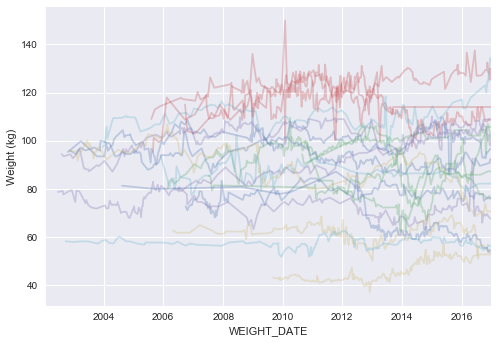

In [24]:
axes = weights_by_patient[np.random.choice(weights_by_patient.columns, 20)].resample('W').mean().interpolate().plot(legend=False, alpha=0.3)
axes.set_ylabel('Weight (kg)')

Add a relative date (to first measurement) of each measurement

In [25]:
relative_date = (filtered_weights.groupby('MRN')
         .apply(lambda patient: patient.WEIGHT_DATE - patient.WEIGHT_DATE.min()))
relative_date.index = relative_date.index.droplevel('MRN')
relative_date.head()
relative_date.name = 'RELATIVE_DATE'

In [26]:
weights = pd.concat([filtered_weights, relative_date], axis=1)

In [27]:
weights_by_patient = pd.pivot_table(weights.assign(Days=weights.RELATIVE_DATE.dt.days), 
                                    index='Days', columns='MRN', values='WEIGHT')

Here is a random 10 trajectories

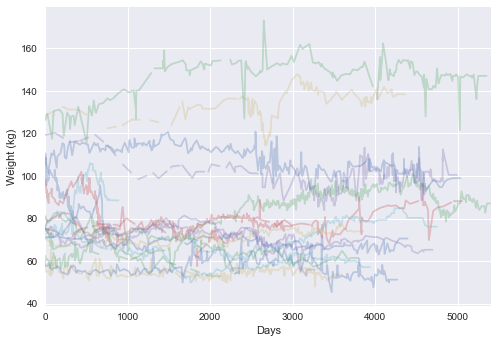

In [28]:
axes = weights_by_patient[np.random.choice(weights_by_patient.columns, 20)].interpolate(limit=100).plot(legend=False, alpha=0.3)
axes.set_ylabel('Weight (kg)');

In [29]:
greevy_200 = pd.read_csv('../data/raw/deltas_200.csv', parse_dates=[1])

Apply Greevy flagging algorihtm

In [30]:
from scipy.stats import chi2

def calc_concordance(patient, m=-0.032, sd=3.52):
    p = []
    for i,x in patient.iterrows():
        # Calculate deltas
        df = (pd.DataFrame({'uid':i, 
                           'delta_W':patient.WEIGHT - x.WEIGHT, 
                           'delta_T':(patient.WEIGHT_DATE - x.WEIGHT_DATE).dt.days.abs()})
             .sort_values('delta_T')[1:11] # Choose closest 10 measurements
             .assign(measurement=np.arange(10)+1, weight_date=x.WEIGHT_DATE)) 
        
        # Calculate statistic
        prob = 1 - chi2.cdf(((df.delta_W - m)/sd) ** 2, 1) 

        # Convert to concordance probability
        p.append({'uid':i, 'p':prob.mean()})
        
    return pd.DataFrame(p).set_index('uid')

In [31]:
from tqdm import tqdm
tqdm.pandas(desc='concordance probability calculation')

In [32]:
concordance = weights.groupby('MRN').progress_apply(calc_concordance)

concordance probability calculation: 100%|██████████| 639/639 [16:58<00:00,  1.34s/it]


In [33]:
concordance.head()

p
MRN     uid             
1287127 485416  0.114945
        485417  0.114945
        485418  0.054747
        485419  0.384672
        485420  0.542418

In [34]:
concordance.index = concordance.index.droplevel('MRN')

In [35]:
(concordance<0.01).mean()


p    0.001903
dtype: float64

Proportion excluded as a function of concordance threshold.

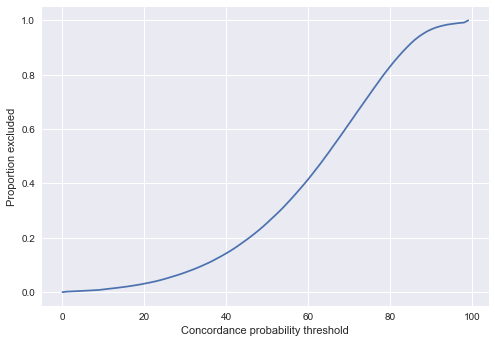

In [36]:
plt.figure()
plt.plot([(concordance<p).mean() for p in np.linspace(0, 1, 100)])
plt.xlabel('Concordance probability threshold')
plt.ylabel('Proportion excluded');

Merge concordance probabilities

In [37]:
weights = weights.join(concordance)

In [167]:
weights['Weight_filtered'] = weights.WEIGHT.copy()
weights.loc[weights.p<0.05, 'Weight_filtered'] = np.nan

In [168]:
weights.head()

,MRN,WEIGHT_DATE,WEIGHT,RELATIVE_DATE,p,Weight_filtered
4076,13857776,2010-07-19,139.03,2742 days,0.612202,139.03
4077,13857776,2005-06-08,100.00,875 days,0.000011,NaN
4078,13857776,2005-02-26,113.60,773 days,0.006936,NaN
4079,13857776,2005-03-21,121.56,796 days,0.343887,121.56
4080,13857776,2005-05-12,121.56,848 days,0.372447,121.56


In [169]:
weights_by_patient = pd.pivot_table(weights.assign(Days=weights.RELATIVE_DATE.dt.days), 
                                    index='Days', columns='MRN', values='Weight_filtered')

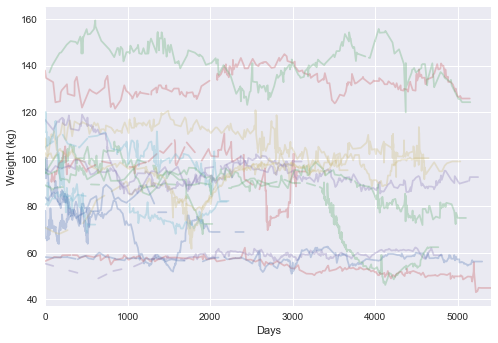

In [171]:
fig, axes = plt.subplots()
(weights_by_patient[np.random.choice(weights_by_patient.columns, 20)]
            .interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

Restrict to the first 1-year period

In [172]:
from datetime import timedelta

ONE_YEAR = timedelta(days=365)

In [185]:
weights_year = weights[weights.RELATIVE_DATE < ONE_YEAR]

In [186]:
measurement_counts = weights_year.groupby('MRN').WEIGHT_DATE.count()

In [187]:
analysis_subset = weights_year[weights_year.MRN.isin(measurement_counts[measurement_counts>50].index)]

In [188]:
analysis_subset.shape

(12175, 6)

In [189]:
weights_by_patient = pd.pivot_table(analysis_subset.assign(Days=analysis_subset.RELATIVE_DATE.dt.days), 
                                    index='Days', columns='MRN', values='Weight_filtered')

In [190]:
weights_by_patient.count().shape

(111,)

In [191]:
change_by_patient = weights_by_patient - weights_by_patient.loc[0]

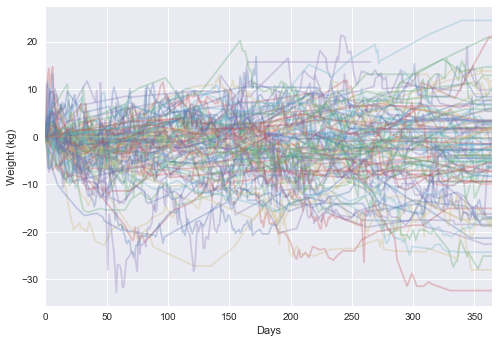

In [192]:
fig, axes = plt.subplots()
(change_by_patient.interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

In [193]:
change_by_patient.to_csv('../data/clean/weight_change_year.csv')

### Lab values

In [42]:
lab_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_Lab_20170213.csv', 
                      usecols = ['MRN','LAB_DATE','LAB_VALUE','LAB_NAME','LAB_UNIT'],
                      parse_dates=[1], infer_datetime_format=True)
lab_raw.head()

,MRN,LAB_DATE,LAB_VALUE,LAB_NAME,LAB_UNIT
0,2156149,10/09/2013,1.09,Creat,mg/dL
1,2156149,10/09/2013,1.04,Creat,mg/dL
2,2156149,10/09/2013,0.89,Creat,mg/dL
3,2156149,10/10/2013,0.89,Creat,mg/dL
4,2156149,10/10/2013,0.97,Creat,mg/dL


In [43]:
lab_raw.shape

(8496974, 5)

### ICD codes

In [44]:
icd_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_ICD_9_10_20170116.csv', 
                      parse_dates=[1], infer_datetime_format=True)
icd_raw.head()

,MRN,EVENT_DATE,ICD_CODE,CODE_TYPE
0,2360139,2003-01-07,401.1,9
1,2360139,2002-01-08,401.1,9
2,2360139,2003-01-08,401.1,9
3,2360139,2005-01-11,401.1,9
4,2360139,2004-01-13,401.9,9


In [45]:
icd_raw.shape

(8796137, 4)

In [46]:
icd_raw.CODE_TYPE.value_counts()


9     7098563
10    1697574
Name: CODE_TYPE, dtype: int64

### Height measurements

Perhaps choose modal or median for each patient.

In [47]:
height_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_Height_20170213.csv', 
                         parse_dates=[1], infer_datetime_format=True)
height_raw.head()

,MRN,HEIGHT_DATE,HEIGHT
0,1887330,2016-02-22,157.48
1,1887330,2012-01-17,162.56
2,1887330,2013-02-15,162.56
3,1887330,2013-05-17,162.56
4,1887330,2013-08-07,162.56


In [48]:
height_raw.shape

(4897313, 3)

In [49]:
height_raw.HEIGHT[(height_raw.HEIGHT<200) & (height_raw.HEIGHT>0) ].shape

(4890749,)

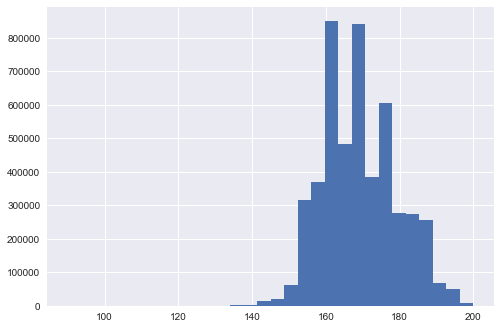

In [50]:
plt.figure()
height_raw.HEIGHT[(height_raw.HEIGHT<200) & (height_raw.HEIGHT>0) ].hist(bins=30)

### CPT codes

In [51]:
cpt_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_CPT_20170116.csv',
                     parse_dates=[1], infer_datetime_format=True)
cpt_raw.head()

,MRN,CPT_DATE,CPT_CODE
0,31275076,2012-05-29,43775
1,31275076,2012-05-29,43775
2,31275076,2012-05-29,43775
3,31275076,2012-05-29,43775
4,31275076,2012-05-29,43775


In [52]:
cpt_raw.isnull().mean()


MRN         0.0
CPT_DATE    0.0
CPT_CODE    0.0
dtype: float64

In [53]:
demographics_raw.merge(cpt_raw, left_index=True, right_on='MRN', how='inner').shape

(65769, 12)